# Sentiment Analysis

<a id="0"></a>
#### Contents:
* [1. Dataset](#1)
    * [1.1. Loading Data](#1.1)
    * [1.2. Data Preprocessing](#1.2)
    * [1.3. Dataset Visualization](#1.3)
* [2. Classifiers](#2)
    * [2.1. Naive Bayes Classfication](#2.1)
    * [2.2. K-Nearest Neighbour Classification](#2.2)
    * [2.3. Support Vector Machine (SVM) Classification](#2.3)
    * [2.4. Decision Tree Machine Classification](#2.3)
* [Advanced. Emotions in data](#advanced)

In [1]:
# !pip install langdetect
# !pip install regex
# !pip install tqdm
# !pip install nltk
# !pip install imblearn
# !pip install tensorflow
# !pip install transformers
# !pip install wordcloud
# !pip install jinja2

In [2]:
# Import libraries
import ast
import pandas as pd
import numpy as np
import regex as re
import string
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import random
from tqdm import tqdm
tqdm.pandas()

# preprocessing 
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from langdetect import detect
from langdetect import DetectorFactory
from imblearn.under_sampling import RandomUnderSampler

# word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.mode.chained_assignment = None


from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# warnings.filterwarnings(action='ignore')    # to suppress future warnings etc

# Below are for Bert 

# transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

# keras
import tensorflow as tf
from tensorflow import keras

# set seed for reproducibility
seed=42

<a id="1"></a>
[<font size="+2" ><b>1. Dataset Presentation</b></font><br>](#0)

It is wise to explore our dataset first

<a id="1.1"></a>
[<font size="+1" ><b>1.1. Loading Data</b></font><br>](#0)
Load necessary data.

In [3]:
# Removing unused columns
df_outside = pd.read_csv('dataset_transformed.csv', encoding='latin')
df_crawl = pd.read_csv('compiled_tweets.csv')

# df_outside = pd.read_csv("/dbfs/FileStore/shared_uploads/dataset_transformed.csv", encoding='latin')
# df_crawl = pd.read_csv("/dbfs/FileStore/shared_uploads/compiled_tweets.csv", encoding='latin')
df_outside = df_outside[["Text", "Subjectivity", "Polarity"]]
df_crawl = df_crawl[["Text", "Subjectivity", "Polarity"]]
df_crawl = df_crawl[df_crawl['Subjectivity'].notna()].copy()
df = pd.concat([df_crawl, df_outside]).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46016 entries, 0 to 46015
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Text          46016 non-null  object 
 1   Subjectivity  46016 non-null  float64
 2   Polarity      37182 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.1+ MB


<a id="1.2"></a>
[<font size="+1" ><b>1.2. Data Preprocessing</b></font><br>](#0)

As twitter texts are relatively unclean compared with others, special cleaning are applied to remove emojis and links

In [4]:
# set seed
DetectorFactory.seed = 0

def language_detection(x:str):
    text = x.split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        except Exception as e:
            lang = "unknown"
            pass
    return lang

In [5]:
df['Language'] = df['Text'].progress_apply(language_detection)

100%|██████████| 46016/46016 [02:12<00:00, 346.78it/s]


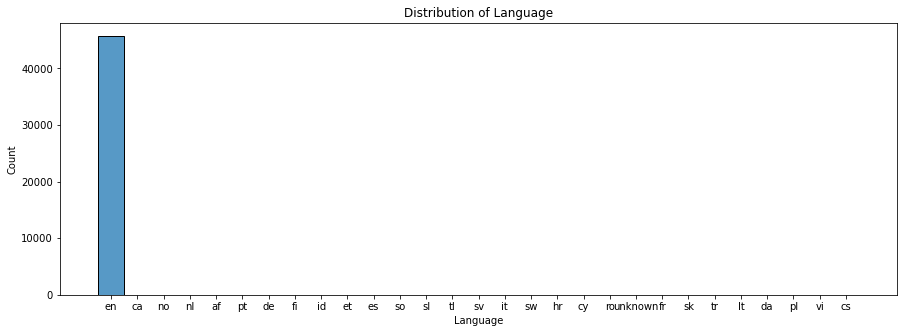

In [6]:
#plot the distribution of language
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=df['Language'])
plt.title("Distribution of Language")
plt.show()

In [7]:
df = df[df['Language'] == 'en'].copy()

In [8]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    # text = re.sub(r'pic.twitter\S+', ' ', text)
    text = re.sub(r'#', '', text)
    text = text.lower()

    return text

def decontracted(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"it\'s", "it is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\“", "", text)
    text = re.sub(r"\”", "", text)
    text = re.sub(r"\…", "", text)

    return text


def remove_punc(tweet):
    tweet =  tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = ' '.join([word for word in tweet.split()])
    tweet = tweet.lower()
    
    return tweet

In [9]:
df['Text'] = df['Text'].progress_apply(clean_text).apply(decontracted).apply(remove_punc)
df.head()

100%|██████████| 45725/45725 [00:01<00:00, 34078.18it/s]


,Text,Subjectivity,Polarity,Language
0,hey kingz crew i just went live on twitch come...,1.0,1.0,en
1,little bit of dbd into apex legends t co fihcg...,0.0,NaN,en
2,tuesday night apex lets get some damage t co d...,1.0,1.0,en
3,watch tohrmentgames go crazy on apex follow up...,1.0,1.0,en
4,live hopping into some apexlegends for a bit c...,0.0,NaN,en


### Stemming

In [10]:
nltk.download('punkt')
nltk.download('stopwords')

def stem_text(x):
    stemmer = PorterStemmer()
    x = word_tokenize(x)
    stem = ''
    
    for i in x:
        stem += stemmer.stem(i) + ' '
        
    return stem

df['stemmed_text'] = df['Text'].progress_apply(stem_text)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ychen21\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ychen21\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 45725/45725 [00:20<00:00, 2221.06it/s]


,Text,Subjectivity,Polarity,Language,stemmed_text
0,hey kingz crew i just went live on twitch come...,1.0,1.0,en,hey kingz crew i just went live on twitch come...
1,little bit of dbd into apex legends t co fihcg...,0.0,NaN,en,littl bit of dbd into apex legend t co fihcgni...
2,tuesday night apex lets get some damage t co d...,1.0,1.0,en,tuesday night apex let get some damag t co dbt...
3,watch tohrmentgames go crazy on apex follow up...,1.0,1.0,en,watch tohrmentgam go crazi on apex follow up c...
4,live hopping into some apexlegends for a bit c...,0.0,NaN,en,live hop into some apexlegend for a bit come o...


### Lemmatization

In [11]:
nltk.download('wordnet')
nltk.download('omw-1.4')

def lemmatize_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in tweet.split()]) for tweet in corpus]

df['lemmatized_text'] = lemmatize_text(df['Text'])
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ychen21\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ychen21\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Text,Subjectivity,Polarity,Language,stemmed_text,lemmatized_text
0,hey kingz crew i just went live on twitch come...,1.0,1.0,en,hey kingz crew i just went live on twitch come...,hey kingz crew i just went live on twitch come...
1,little bit of dbd into apex legends t co fihcg...,0.0,NaN,en,littl bit of dbd into apex legend t co fihcgni...,little bit of dbd into apex legend t co fihcgn...
2,tuesday night apex lets get some damage t co d...,1.0,1.0,en,tuesday night apex let get some damag t co dbt...,tuesday night apex let get some damage t co db...
3,watch tohrmentgames go crazy on apex follow up...,1.0,1.0,en,watch tohrmentgam go crazi on apex follow up c...,watch tohrmentgames go crazy on apex follow up...
4,live hopping into some apexlegends for a bit c...,0.0,NaN,en,live hop into some apexlegend for a bit come o...,live hopping into some apexlegends for a bit c...


### Stopwords Removal

In [12]:
stop = stopwords.words('english')
additional_stopwords = ["'s","...","'ve","``","''","'m",'--',"'ll","'d", 'u', 'b', 'c', 'd', 'x', 'xf', 'f', 'p', 'xb']
stop = set(stop + additional_stopwords)

def remove_stopwords(x):
    x = word_tokenize(x)
    store_words = ''
    
    for i in x:
        if i not in stop:
            store_words += i + ' '
            
    return store_words

In [13]:
df['cleaned_text'] = df['Text'].progress_apply(remove_stopwords)
df['cleaned_stemmed_text'] = df['stemmed_text'].progress_apply(remove_stopwords)
df['cleaned_lemmatized_text'] = df['lemmatized_text'].progress_apply(remove_stopwords)

df.head()

100%|██████████| 45725/45725 [00:04<00:00, 9802.25it/s] 


,Text,Subjectivity,Polarity,Language,stemmed_text,lemmatized_text,cleaned_text,cleaned_stemmed_text,cleaned_lemmatized_text
0,hey kingz crew i just went live on twitch come...,1.0,1.0,en,hey kingz crew i just went live on twitch come...,hey kingz crew i just went live on twitch come...,hey kingz crew went live twitch come chat hang...,hey kingz crew went live twitch come chat hang...,hey kingz crew went live twitch come chat hang...
1,little bit of dbd into apex legends t co fihcg...,0.0,NaN,en,littl bit of dbd into apex legend t co fihcgni...,little bit of dbd into apex legend t co fihcgn...,little bit dbd apex legends co fihcgnia,littl bit dbd apex legend co fihcgnia,little bit dbd apex legend co fihcgnia
2,tuesday night apex lets get some damage t co d...,1.0,1.0,en,tuesday night apex let get some damag t co dbt...,tuesday night apex let get some damage t co db...,tuesday night apex lets get damage co dbt givs...,tuesday night apex let get damag co dbt givsyr...,tuesday night apex let get damage co dbt givsy...
3,watch tohrmentgames go crazy on apex follow up...,1.0,1.0,en,watch tohrmentgam go crazi on apex follow up c...,watch tohrmentgames go crazy on apex follow up...,watch tohrmentgames go crazy apex follow carbo...,watch tohrmentgam go crazi apex follow carbong...,watch tohrmentgames go crazy apex follow carbo...
4,live hopping into some apexlegends for a bit c...,0.0,NaN,en,live hop into some apexlegend for a bit come o...,live hopping into some apexlegends for a bit c...,live hopping apexlegends bit come want witness...,live hop apexlegend bit come want wit decent g...,live hopping apexlegends bit come want witness...


<a id="1.3"></a>
[<font size="+1"><b>1.3. Data Visualization</b></font><br>](#0)

In [14]:
print("========== number of words in the corpus ==========")

print(f"original: {df['Text'].apply(lambda x: len(x.split())).sum()}")

print(f"after stemming: {df['stemmed_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after lemmatization: {df['lemmatized_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after removal of stopwords: {df['cleaned_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after stemming and removal of stopwords: {df['cleaned_stemmed_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after lemmatization and removal of stopwords: {df['cleaned_lemmatized_text'].apply(lambda x: len(x.split())).sum()}")

========== number of words in the corpus ==========
original: 1483627
after stemming: 1484259
after lemmatization: 1483627
after removal of stopwords: 897669
after stemming and removal of stopwords: 925419
after lemmatization and removal of stopwords: 901532


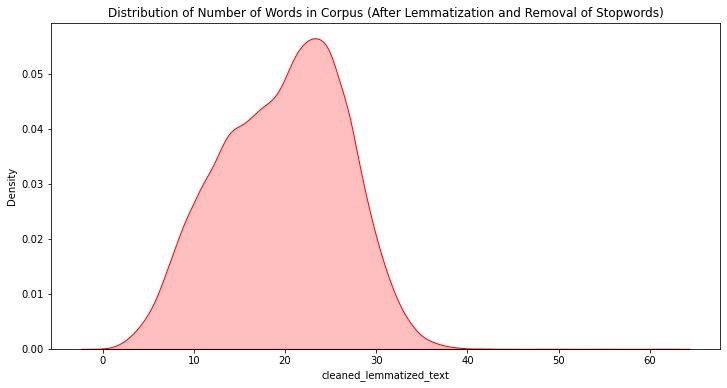

In [15]:
num_words_train = df['cleaned_lemmatized_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
p1=sns.kdeplot(df['cleaned_lemmatized_text'].apply(lambda x: len(x.split())), fill=True, color="r").set_title('Distribution of Number of Words in Corpus (After Lemmatization and Removal of Stopwords)')

In [16]:
word_list_train = df.cleaned_lemmatized_text.str.split()
top = Counter([item for sublist in word_list_train for item in sublist])
temp = pd.DataFrame(top.most_common(15))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,co,26161
1,covid,26120
2,coronavirus,19672
3,store,9530
4,price,9512
5,food,8755
6,supermarket,8388
7,grocery,7674
8,people,6510
9,amp,5838


In [17]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color=color,
                    stopwords = STOPWORDS,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = seed,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

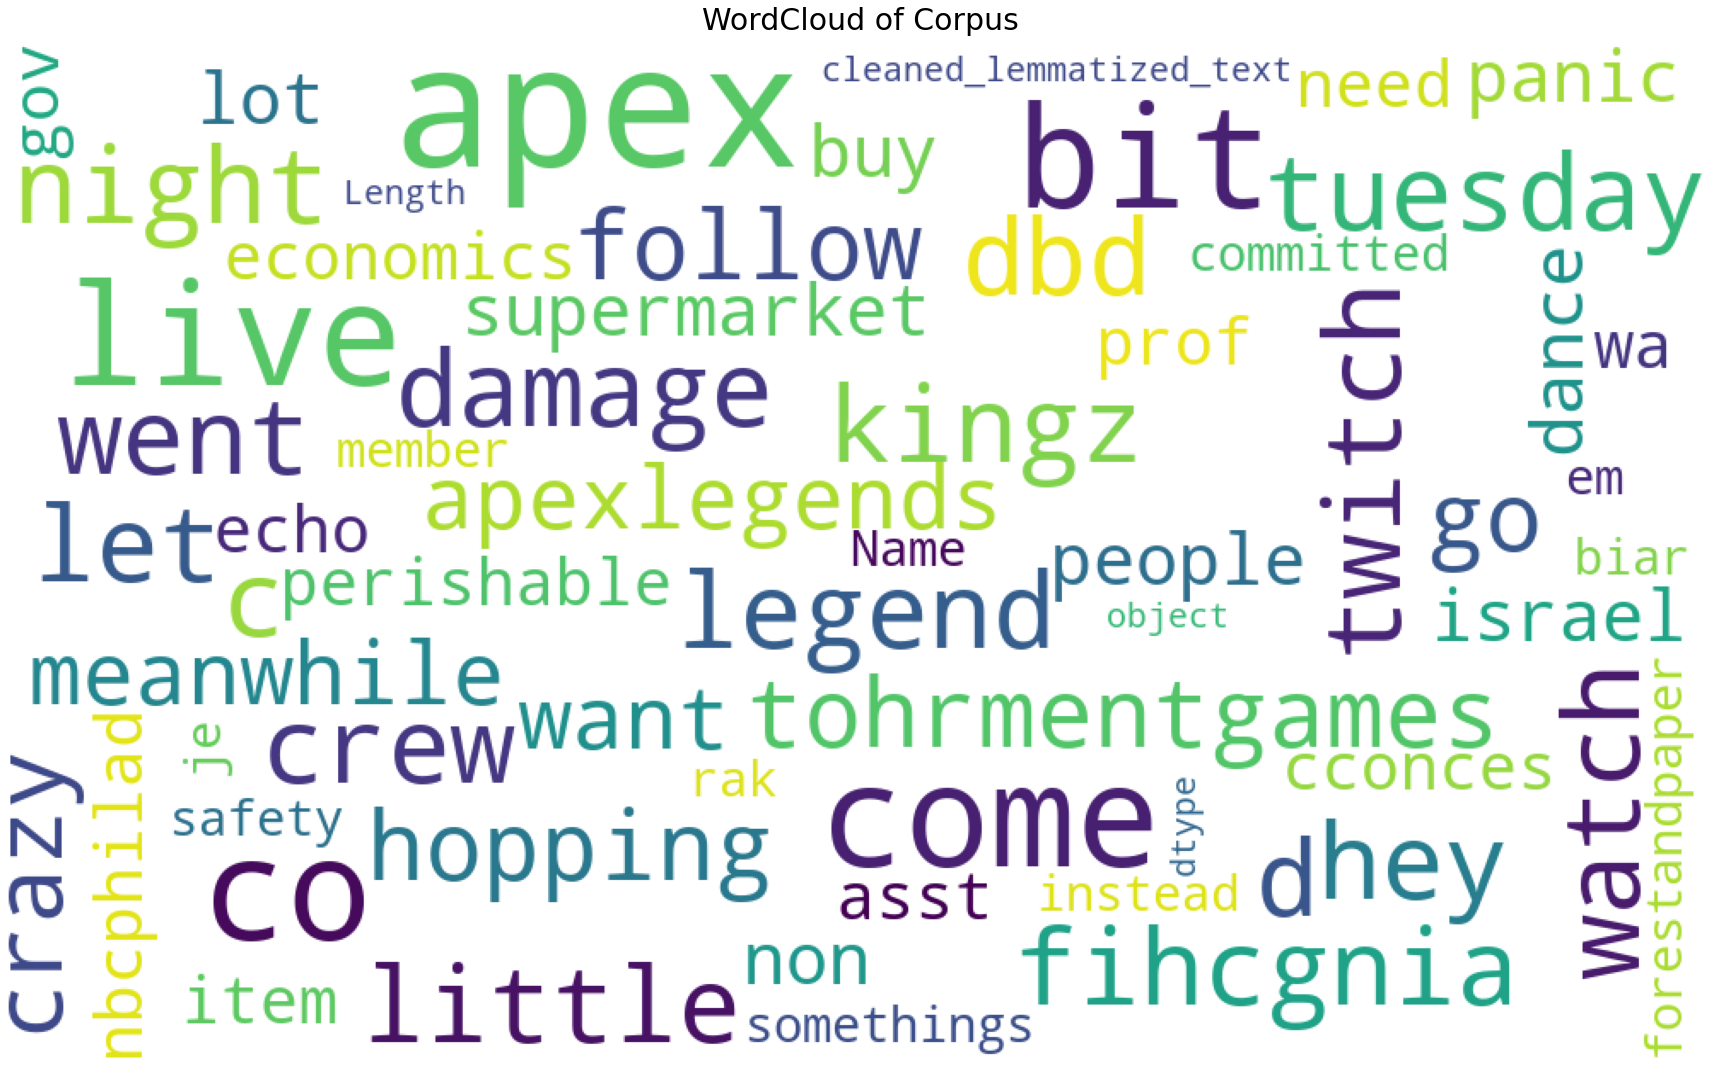

In [18]:
pos_mask = np.array(Image.new('RGB', (1000,600)))
plot_wordcloud(word_list_train, mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Corpus")

<a id="2"></a>
[<font size="+2" ><b>2. Classifiers</b></font><br>](#0)

<a id="2.1"></a>
[<font size="+1" ><b>2.1. Naive Bayes Classification</b></font><br>](#0)

In [19]:
def naiveBayesClassification(x_train, x_test, y_train, y_test, preprocessing):

    naiveBayes_model = MultinomialNB().fit(x_train, y_train)
    result = naiveBayes_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)
    
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Naive Bayes Classification")
    print("Preprocessing Function: ", preprocessing)
    print("==================================================")
    print()
    plt.title("Confusion matrix of Naive Bayes Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score = metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)
    
    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()

<a id="2.2"></a>
[<font size="+1" ><b>2.2. K-Nearest Neighbour (KNN) Classification</b></font><br>](#0)

In [20]:
def KNNClassification(x_train, x_valid, x_test, y_train, y_valid, y_test, preprocessing, best_params=None):

    if best_params is None:
        
        print("Searching for best parameters")

        metric = ['euclidean', 'manhattan', 'cosine']
        neighbors = list(range(1,30))
        leaf_size = list(range(1,50))
        weight = ['uniform', 'distance']
        param_grid = {'metric' : metric, 'n_neighbors': neighbors, 'weights' : weight, 'leaf_size' : leaf_size}
        
        grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3)
        grid_search.fit(x_valid, y_valid)

        best_params = grid_search.best_params_
    
    
    knn_model = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'], metric= best_params['metric'], leaf_size = best_params['leaf_size'], weights = best_params['weights'])
    knn_model.fit(x_train, y_train)   
    
    result = knn_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: K-Nearest Neighbour Classification")
    print("Best parameters:", best_params)
    print("Preprocessing Function: ", preprocessing)
    print("==================================================")
    print()
    plt.title("Confusion matrix of KNN Classification of tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()
  

<a id="2.3"></a>
[<font size="+1" ><b>2.3. Support Vector Machine (SVM) Classification</b></font><br>](#0)

In [21]:
def SVMClassification(x_train, x_valid, x_test, y_train, y_valid, y_test, preprocessing, best_params=None):

    if best_params is None:
        
        print("Searching for best parameters")

        Cs = [0.001, 0.01, 0.1, 1, 10]
        gammas = [0.05, 0.1, 0.15, 0.20, 0.25]
        degrees = [0, 1, 2, 3, 4, 5, 6]
        kernels = ['rbf', 'linear', 'poly']
        param_grid = {'C': Cs, 'gamma' : gammas, 'degree' : degrees, 'kernel' : kernels}
        
        grid_search = GridSearchCV(svm.SVC(), param_grid, cv = 3)
        grid_search.fit(x_valid, y_valid)

        best_params = grid_search.best_params_

    SVM_model = svm.SVC(C = best_params['C'], kernel = best_params['kernel'], gamma = best_params['gamma'], degree = best_params['degree'], random_state=seed)
    SVM_model.fit(x_train, y_train)
    
    result = SVM_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)
    
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Support Vector Machine Classification")
    print("Preprocessing Function: ", preprocessing)
    print("Best parameters:", best_params)
    print("==================================================")
    print()
    plt.title("Confusion matrix of SVM Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()

<a id="2.4"></a>
[<font size="+1" ><b>2.4. Decision Tree Classification</b></font><br>](#0)

In [22]:
def decisionTreeClassification(x_train, x_valid, x_test, y_train, y_valid, y_test, preprocessing, best_params=None):
    
    clf = DecisionTreeClassifier() 

    if best_params is None:
            
        print("Searching for best parameters")
        param_grid = { 
            'criterion': ['gini','entropy'],
            'splitter': ['best','random'],
            'max_features': ['sqrt','log2']
        }
        
        grid_search = GridSearchCV(clf, param_grid, cv= 3)
        grid_search.fit(x_valid, y_valid)
        best_params = grid_search.best_params_

    decisionTree_model = DecisionTreeClassifier(criterion = best_params['criterion'],splitter = best_params['splitter'], max_features = best_params['max_features'], random_state=seed)
    decisionTree_model.fit(x_train, y_train)

    result = decisionTree_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)


    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Decision Tree Classification")
    print("Preprocessing Function: ", preprocessing)
    print("Best parameters:", best_params)
    print("==================================================")
    print()
    plt.title("Confusion matrix of Decision Tree Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()

<a id="3"></a>
[<font size="+2" ><b>3. Training</b></font><br>](#0)

In [23]:
# don't consider uncleaned text for now (too much noise)
preprocessings = ['cleaned_stemmed_text', 'cleaned_lemmatized_text', 'cleaned_text'] 

<a id="3"></a>
[<font size="+1" ><b>3.1. Vectorization</b></font><br>](#0)

In [24]:
df = df[df['Subjectivity'].notna()].copy()
df['Subjectivity'].value_counts()

0.0    37000
1.0     8725
Name: Subjectivity, dtype: int64

We can see that here the class is highly unbalanced with too many biased content. For better output, we need to balance the dataset first

In [25]:
#  Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset.
sampler = RandomUnderSampler(random_state=seed)
X_sub, Y_sub = sampler.fit_resample(df[preprocessings], df['Subjectivity'])
Y_sub.value_counts()

0.0    8725
1.0    8725
Name: Subjectivity, dtype: int64

In [26]:
# do the same for 'Polarity'
polar_df = df[df['Polarity'].notna()].copy()
polar_df['Polarity'].value_counts()

1.0    19809
0.0    17256
Name: Polarity, dtype: int64

In [27]:
X_polar, Y_polar = sampler.fit_resample(polar_df[preprocessings], polar_df['Polarity'])
Y_polar.value_counts()

0.0    17256
1.0    17256
Name: Polarity, dtype: int64

<b> Train, test, cv split </b>

In [28]:
# for subjectivity, get train set, valid set (cross validation), andn test set
X_train_valid_sub, X_test_sub, y_train_valid_sub, y_test_sub = train_test_split(X_sub, 
                                                    Y_sub,
                                                    test_size = 0.3, 
                                                    random_state = seed, stratify=Y_sub)
X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(X_train_valid_sub, 
                                                    y_train_valid_sub,
                                                    test_size = 0.1, 
                                                    random_state = seed, stratify=y_train_valid_sub)

print(f"Shape of X_train: {X_train_sub.shape}")
print(f"Shape of y_train: {y_train_sub.shape}")
print(f"Shape of X_valid: {X_valid_sub.shape}")
print(f"Shape of y_valid: {y_valid_sub.shape}")
print(f"Shape of X_test: {X_test_sub.shape}")
print(f"Shape of y_test: {y_test_sub.shape}")

Shape of X_train: (10993, 3)
Shape of y_train: (10993,)
Shape of X_valid: (1222, 3)
Shape of y_valid: (1222,)
Shape of X_test: (5235, 3)
Shape of y_test: (5235,)


In [29]:
# for polarity, get train set, valid set (cross validation), andn test set
X_train_valid_polar, X_test_polar, y_train_valid_polar, y_test_polar = train_test_split(X_polar, 
                                                    Y_polar,
                                                    test_size = 0.3, 
                                                    random_state = seed, stratify=Y_polar)
X_train_polar, X_valid_polar, y_train_polar, y_valid_polar = train_test_split(X_train_valid_polar, 
                                                    y_train_valid_polar,
                                                    test_size = 0.1, 
                                                    random_state = seed, stratify=y_train_valid_polar)

print(f"Shape of X_train: {X_train_polar.shape}")
print(f"Shape of y_train: {y_train_polar.shape}")
print(f"Shape of X_valid: {X_valid_polar.shape}")
print(f"Shape of y_valid: {y_valid_polar.shape}")
print(f"Shape of X_test: {X_test_polar.shape}")
print(f"Shape of y_test: {y_test_polar.shape}")

Shape of X_train: (21742, 3)
Shape of y_train: (21742,)
Shape of X_valid: (2416, 3)
Shape of y_valid: (2416,)
Shape of X_test: (10354, 3)
Shape of y_test: (10354,)


In [30]:
vec_X_train_sub = {}
vec_X_valid_sub = {}
vec_X_test_sub = {}
# The CountVectorizer will select the words/features/terms which occur the most frequently. It takes absolute values so if you set the 'max_features = 3', it will select the 3 most common words in the data.
for method in preprocessings:
    clf = CountVectorizer(ngram_range=(1,2), max_features=2**9).fit(X_train_sub[method])
    X_train_cv =  clf.transform(X_train_sub[method])
    X_valid_cv = clf.transform(X_valid_sub[method])
    X_test_cv = clf.transform(X_test_sub[method])
    
    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
    vec_X_train_sub[method] = tf_transformer.transform(X_train_cv)
    vec_X_valid_sub[method] = tf_transformer.transform(X_valid_cv)
    vec_X_test_sub[method] = tf_transformer.transform(X_test_cv)

In [31]:
vec_X_train_polar = {}
vec_X_valid_polar = {}
vec_X_test_polar = {}

for method in preprocessings:
    clf = CountVectorizer(ngram_range=(1,2), max_features=2**9).fit(X_train_polar[method])
    X_train_cv =  clf.transform(X_train_polar[method])
    X_valid_cv = clf.transform(X_valid_polar[method])
    X_test_cv = clf.transform(X_test_polar[method])
    
    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
    vec_X_train_polar[method] = tf_transformer.transform(X_train_cv)
    vec_X_valid_polar[method] = tf_transformer.transform(X_valid_cv)
    vec_X_test_polar[method] = tf_transformer.transform(X_test_cv)

<a id="3.2"></a>
[<font size="+1" ><b>3.2. Subjectivity Classification & Evaluation </b></font><br>](#0)

We use naive bayes model's performance as the baseline for measurements of other models.

In [32]:
best_params_df = pd.read_csv("Best_Params.csv")
best_params_df

,model,task,input,best_params
0,KNN,subjectivity,cleaned_stemmed_text,"{'leaf_size': 1, 'metric': 'cosine', 'n_neighb..."
1,SVM,subjectivity,cleaned_stemmed_text,"{'C': 10, 'degree': 1, 'gamma': 0.05, 'kernel'..."
2,DecisionTree,subjectivity,cleaned_stemmed_text,"{'criterion': 'entropy', 'max_features': 'sqrt..."
3,KNN,subjectivity,cleaned_lemmatized_text,"{'leaf_size': 1, 'metric': 'cosine', 'n_neighb..."
4,SVM,subjectivity,cleaned_lemmatized_text,"{'C': 10, 'degree': 0, 'gamma': 0.2, 'kernel':..."
5,DecisionTree,subjectivity,cleaned_lemmatized_text,"{'criterion': 'entropy', 'max_features': 'log2..."
6,KNN,subjectivity,cleaned_text,"{'leaf_size': 1, 'metric': 'cosine', 'n_neighb..."
7,SVM,subjectivity,cleaned_text,"{'C': 10, 'degree': 1, 'gamma': 0.2, 'kernel':..."
8,DecisionTree,subjectivity,cleaned_text,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
9,KNN,polarity,cleaned_stemmed_text,"{'leaf_size': 1, 'metric': 'cosine', 'n_neighb..."


In [33]:
def get_best_params(model_name: str, task: str, src:str):
    param = best_params_df[(best_params_df['model'] == model_name) & (best_params_df['task']==task) & (best_params_df['input'] == src)]['best_params'].values[0]
    try:
        return ast.literal_eval(param)
    except:
        return None

In [34]:
def base_line_performance(processing_idx:int, task: str):
    print("Base line")
    method = preprocessings[processing_idx]
    if task == 'subjectivity':
        x_train = vec_X_train_sub[method]
        x_test = vec_X_test_sub[method]
        y_train = y_train_sub
        y_test = y_test_sub
    else:
        x_train = vec_X_train_polar[method]
        x_test = vec_X_test_polar[method]
        y_train = y_train_polar
        y_test = y_test_polar
        
    naiveBayesClassification(x_train, x_test, y_train, y_test, method)

In [35]:
def classifier_performance(processing_idx:int, task: str):
    method = preprocessings[processing_idx]
    if task == 'subjectivity':
        x_train = vec_X_train_sub[method]
        x_valid = vec_X_valid_sub[method]
        x_test = vec_X_test_sub[method]
        y_train = y_train_sub
        y_valid = y_valid_sub
        y_test = y_test_sub
    else:
        x_train = vec_X_train_polar[method]
        x_valid = vec_X_valid_polar[method]
        x_test = vec_X_test_polar[method]
        y_train = y_train_polar
        y_valid = y_valid_polar
        y_test = y_test_polar

    decisionTreeClassification(
        x_train,
        x_valid,
        x_test,
        y_train,
        y_valid,
        y_test,
        method, 
        get_best_params('DecisionTree', task, method))

    SVMClassification(
        x_train,
        x_valid,
        x_test,
        y_train,
        y_valid,
        y_test,
        method, 
        get_best_params('SVM', task, method)
    )

    KNNClassification(
        x_train,
        x_valid,
        x_test,
        y_train,
        y_valid,
        y_test,
        method, 
        get_best_params('KNN', 'subjectivity', 'cleaned_stemmed_text')
    )

<b> 3.2.1 Subjectivity with Cleaned Stemmed Text </b><br>
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_stemmed_text



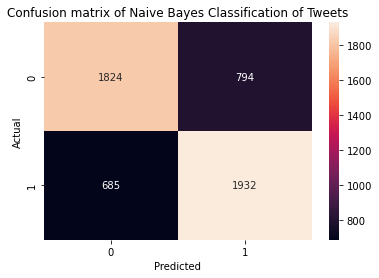

------------ Evaluation Metrics ----------------

F1 score: 0.723
Precision score: 0.709
Recall score: 0.738
Average precision-recall score: 0.654



In [36]:
base_line_performance(0,'subjectivity')

Model: Decision Tree Classification
Preprocessing Function:  cleaned_stemmed_text
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'random'}



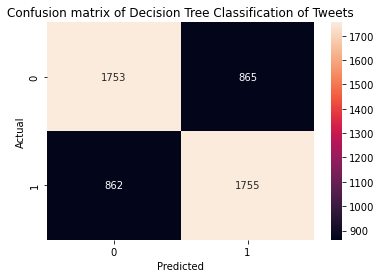

------------ Evaluation Metrics ----------------

F1 score: 0.670
Precision score: 0.670
Recall score: 0.671
Average precision-recall score: 0.614

Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_stemmed_text
Best parameters: {'C': 10, 'degree': 1, 'gamma': 0.05, 'kernel': 'poly'}



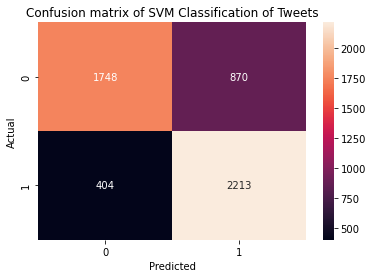

------------ Evaluation Metrics ----------------

F1 score: 0.776
Precision score: 0.718
Recall score: 0.846
Average precision-recall score: 0.684

Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 9, 'weights': 'distance'}
Preprocessing Function:  cleaned_stemmed_text



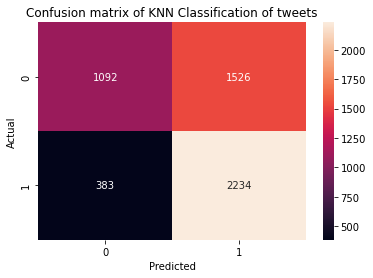

------------ Evaluation Metrics ----------------

F1 score: 0.701
Precision score: 0.594
Recall score: 0.854
Average precision-recall score: 0.580



In [37]:
classifier_performance(0,'subjectivity')

<b> 3.2.2 Subjectivity with Cleaned Lemmatized Text </b><br>
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_lemmatized_text



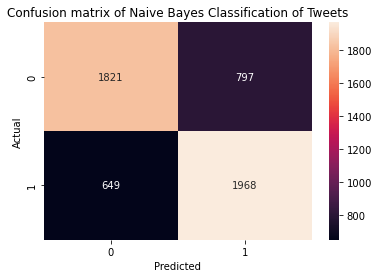

------------ Evaluation Metrics ----------------

F1 score: 0.731
Precision score: 0.712
Recall score: 0.752
Average precision-recall score: 0.659



In [38]:
base_line_performance(1,'subjectivity')

Model: Decision Tree Classification
Preprocessing Function:  cleaned_lemmatized_text
Best parameters: {'criterion': 'entropy', 'max_features': 'log2', 'splitter': 'random'}



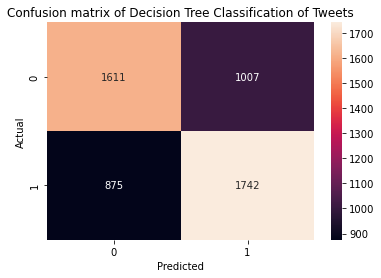

------------ Evaluation Metrics ----------------

F1 score: 0.649
Precision score: 0.634
Recall score: 0.666
Average precision-recall score: 0.589

Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_lemmatized_text
Best parameters: {'C': 10, 'degree': 0, 'gamma': 0.2, 'kernel': 'rbf'}



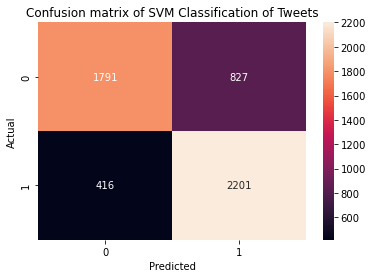

------------ Evaluation Metrics ----------------

F1 score: 0.780
Precision score: 0.727
Recall score: 0.841
Average precision-recall score: 0.691

Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 9, 'weights': 'distance'}
Preprocessing Function:  cleaned_lemmatized_text



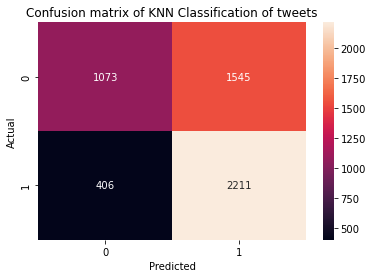

------------ Evaluation Metrics ----------------

F1 score: 0.694
Precision score: 0.589
Recall score: 0.845
Average precision-recall score: 0.575



In [39]:
classifier_performance(1,'subjectivity')

<b> 3.2.3 Subjectivity with Cleaned Text </b><br>
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_text



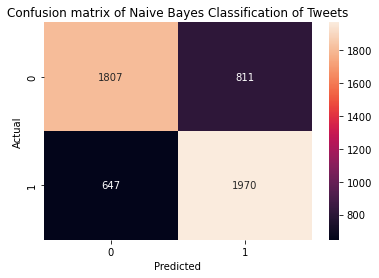

------------ Evaluation Metrics ----------------

F1 score: 0.730
Precision score: 0.708
Recall score: 0.753
Average precision-recall score: 0.657



In [40]:
base_line_performance(2, 'subjectivity')

Model: Decision Tree Classification
Preprocessing Function:  cleaned_text
Best parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'random'}



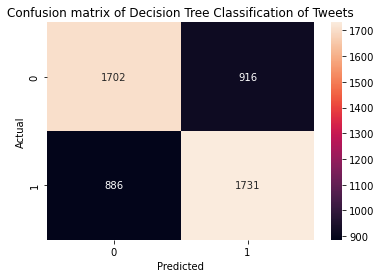

------------ Evaluation Metrics ----------------

F1 score: 0.658
Precision score: 0.654
Recall score: 0.661
Average precision-recall score: 0.602

Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_text
Best parameters: {'C': 10, 'degree': 1, 'gamma': 0.2, 'kernel': 'poly'}



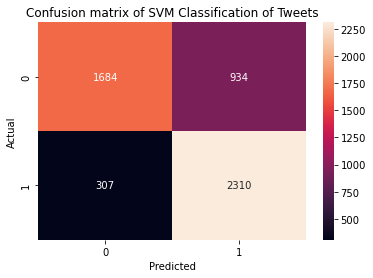

------------ Evaluation Metrics ----------------

F1 score: 0.788
Precision score: 0.712
Recall score: 0.883
Average precision-recall score: 0.687

Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 9, 'weights': 'distance'}
Preprocessing Function:  cleaned_text



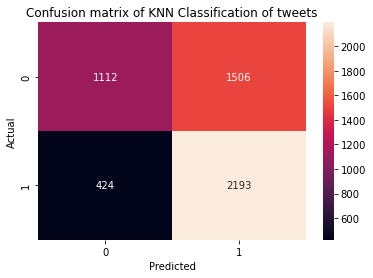

------------ Evaluation Metrics ----------------

F1 score: 0.694
Precision score: 0.593
Recall score: 0.838
Average precision-recall score: 0.578



In [41]:
classifier_performance(2, 'subjectivity')

<a id="3.3"></a>
[<font size="+1" ><b>3.3. Polarity Classification & Evaluation </b></font><br>](#0)

We use naive bayes model's performance as the baseline for measurements of other models.

<b> 3.3.1 Polarity with Cleaned Stemmed Text </b><br>
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_stemmed_text



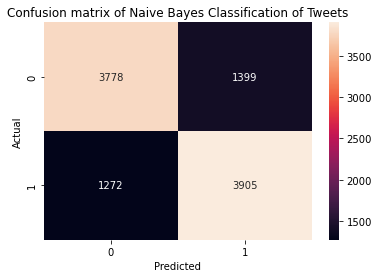

------------ Evaluation Metrics ----------------

F1 score: 0.745
Precision score: 0.736
Recall score: 0.754
Average precision-recall score: 0.678



In [42]:
base_line_performance(0,'polarity')

Model: Decision Tree Classification
Preprocessing Function:  cleaned_stemmed_text
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}



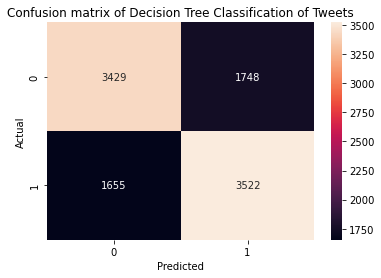

------------ Evaluation Metrics ----------------

F1 score: 0.674
Precision score: 0.668
Recall score: 0.680
Average precision-recall score: 0.615

Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_stemmed_text
Best parameters: {'C': 10, 'degree': 1, 'gamma': 0.05, 'kernel': 'poly'}



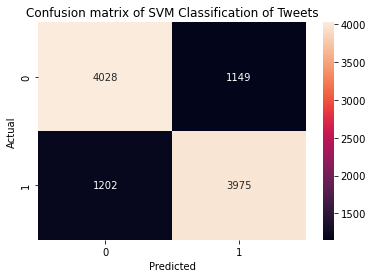

------------ Evaluation Metrics ----------------

F1 score: 0.772
Precision score: 0.776
Recall score: 0.768
Average precision-recall score: 0.712

Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 9, 'weights': 'distance'}
Preprocessing Function:  cleaned_stemmed_text



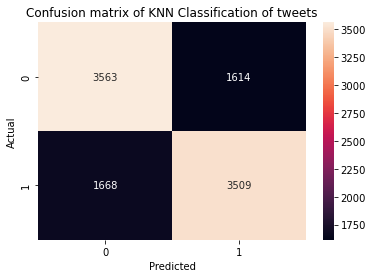

------------ Evaluation Metrics ----------------

F1 score: 0.681
Precision score: 0.685
Recall score: 0.678
Average precision-recall score: 0.625



In [43]:
classifier_performance(0,'polarity')

<b> 3.3.2 Polarity with Cleaned Lemmatized Text </b><br>
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_lemmatized_text



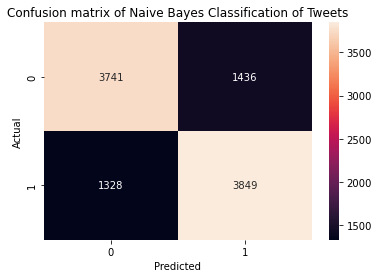

------------ Evaluation Metrics ----------------

F1 score: 0.736
Precision score: 0.728
Recall score: 0.743
Average precision-recall score: 0.670



In [44]:
base_line_performance(1,'polarity')

Model: Decision Tree Classification
Preprocessing Function:  cleaned_lemmatized_text
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}



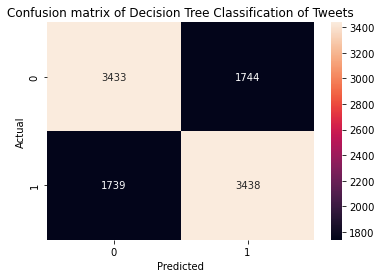

------------ Evaluation Metrics ----------------

F1 score: 0.664
Precision score: 0.663
Recall score: 0.664
Average precision-recall score: 0.609

Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_lemmatized_text
Best parameters: {'C': 10, 'degree': 1, 'gamma': 0.2, 'kernel': 'poly'}



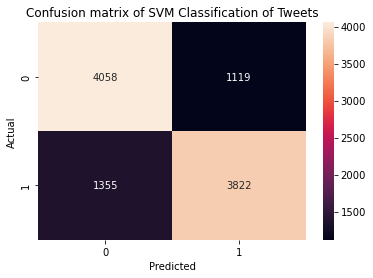

------------ Evaluation Metrics ----------------

F1 score: 0.755
Precision score: 0.774
Recall score: 0.738
Average precision-recall score: 0.702

Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 9, 'weights': 'distance'}
Preprocessing Function:  cleaned_lemmatized_text



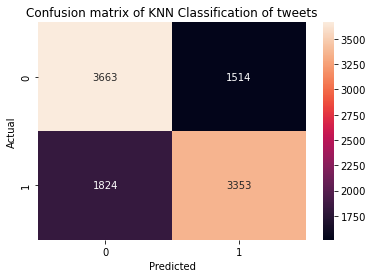

------------ Evaluation Metrics ----------------

F1 score: 0.668
Precision score: 0.689
Recall score: 0.648
Average precision-recall score: 0.622



In [45]:
classifier_performance(1,'polarity')

<b> 3.3.3 Polarity with Cleaned Text </b><br>
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_text



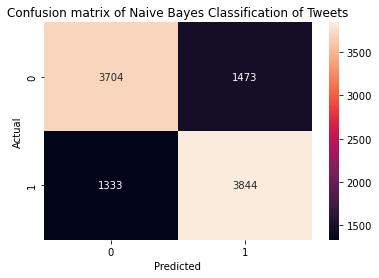

------------ Evaluation Metrics ----------------

F1 score: 0.733
Precision score: 0.723
Recall score: 0.743
Average precision-recall score: 0.666



In [46]:
base_line_performance(2, 'polarity')

Model: Decision Tree Classification
Preprocessing Function:  cleaned_text
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'random'}



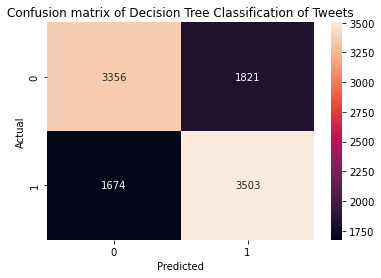

------------ Evaluation Metrics ----------------

F1 score: 0.667
Precision score: 0.658
Recall score: 0.677
Average precision-recall score: 0.607

Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_text
Best parameters: {'C': 1, 'degree': 0, 'gamma': 0.2, 'kernel': 'rbf'}



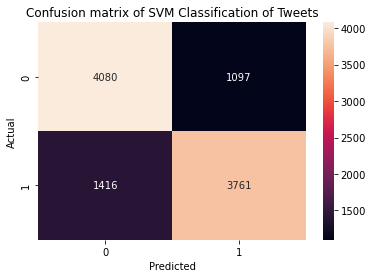

------------ Evaluation Metrics ----------------

F1 score: 0.750
Precision score: 0.774
Recall score: 0.726
Average precision-recall score: 0.699

Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 9, 'weights': 'distance'}
Preprocessing Function:  cleaned_text



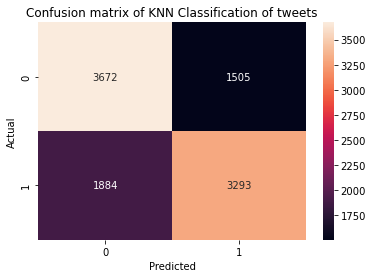

------------ Evaluation Metrics ----------------

F1 score: 0.660
Precision score: 0.686
Recall score: 0.636
Average precision-recall score: 0.619



In [47]:
classifier_performance(2, 'polarity')

<a id="3"></a>
[<font size="+2" ><b>Innovation1: Traditionoal Classifiers vs Bert</b></font><br>](#0)

<a id="3.1"></a>
[<font size="+1" ><b>Subjectivity</b></font><br>](#0)

In [48]:
MAX_LEN=128
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            text=data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [49]:
train_input_ids, train_attention_masks = tokenize(list(X_train_sub['cleaned_text']), MAX_LEN)
val_input_ids, val_attention_masks = tokenize(list(X_valid_sub['cleaned_text']), MAX_LEN)
test_input_ids, test_attention_masks = tokenize(list(X_test_sub['cleaned_text']), MAX_LEN)

In [50]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [51]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(1, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    return model

In [52]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [53]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [54]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


history_bert = model.fit([train_input_ids,train_attention_masks], y_train_sub, validation_data=([val_input_ids,val_attention_masks], y_valid_sub), epochs=4, batch_size=32, callbacks=[cp_callback])  # Pass callback to training

Epoch 1/4
227/344 [==================>...........] - ETA: 35:19 - loss: 0.0000e+00 - categorical_accuracy: 1.0000

In [ ]:
y_pred_bert = model.predict([test_input_ids,test_attention_masks])

In [ ]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(5,5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [ ]:
conf_matrix(y_test_sub, y_pred_bert,'BERT Subjectivity Analysis\nConfusion Matrix', ['Subjective', 'Opinionated'])

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test_sub,y_pred_bert, target_names=['Subjective', 'Opinionated']))

<a id="3.1"></a>
[<font size="+1" ><b>Polarity</b></font><br>](#0)

In [ ]:
polar_train_input_ids, polar_train_attention_masks = tokenize(X_train_polar, MAX_LEN)
polar_val_input_ids, polar_val_attention_masks = tokenize(X_valid_polar, MAX_LEN)
polar_test_input_ids, polar_test_attention_masks = tokenize(X_test_polar, MAX_LEN)

In [ ]:
polar_model = create_model(bert_model, MAX_LEN)
history_bert_polar = model.fit([polar_train_input_ids,polar_train_attention_masks], y_train_polar, validation_data=([polar_val_input_ids,polar_val_attention_masks], y_valid_polar), epochs=4, batch_size=32)

In [ ]:
y_pred_bert_polar = model.predict([polar_test_input_ids, polar_test_attention_masks])

In [ ]:
conf_matrix(y_test_polar, y_pred_bert,'BERT Subjectivity Analysis\nConfusion Matrix', ['Positive', 'Negative'])

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test_polar,y_pred_bert_polar, target_names=['Positive', 'Negative']))

<a id="4"></a>
[<font size="+2" ><b>Innovation2: Two subtask with bert using one-hot-encoding</b></font><br>](#0)